In [38]:
### This project will implement the Generative model for face classification
### (classifying face images from non-face/background images).
### @Yajie Wang, Stony Brook University, Fall 2021
import cv2
import numpy as  np
import matplotlib.pyplot as plt
import scipy.stats

In [39]:
### File directory

# Change the directory to run the program

# Training data directory
training_datadir= '/Users/yajiewang/Downloads/353img/trainingData/'

# Testing data directory
testing_datadir= '/Users/yajiewang/Downloads/353img/testingData/'

# Initialization
trainingImagesBg = []
trainingImagesFace = []
testingImagesBg = []
testingImagesFace = []
n_bg_train = 249 # number of training background images
n_face_train = 184 # number of training face images
n_bg_test = 564 # number of testing background images
n_face_test = 232 # number of testing face images
for i in range(n_bg_train):
    trainingImagesBg.append(i + 1)

for i in range(n_face_train):
    trainingImagesFace.append(i + 1)
    
for i in range(n_bg_test):
    testingImagesBg.append(i + 1)

for i in range(n_face_test):
    testingImagesFace.append(i + 1)
###

In [40]:
### Training process
# face training
n_rgb = 900 # number of rgb values we use
training_face = np.zeros((n_rgb, n_face_train))
mu_training_face = np.zeros((n_rgb, 1))
var_training_face = np.zeros((n_rgb, n_rgb))
for iFile in trainingImagesFace:
    # Load the training image
    if ( iFile < 10 ):
        origIm = cv2.imread(training_datadir + 'face/00' + str(iFile) + '.jpg')  
    
    
    if ( iFile >= 10 and iFile < 100 ):
        origIm = cv2.imread(training_datadir + 'face/0' + str(iFile) + '.jpg')  
        
    
    if ( iFile >= 100 ):
        origIm = cv2.imread(training_datadir + 'face/' + str(iFile) + '.jpg')  
    
    nrows, ncols = origIm.shape[0], origIm.shape[1]
                     


# store RGB values of the face images into a 2D array
    k = 0
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_face[k][iFile-1] = origIm[i][j][0] # Blue
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_face[k][iFile-1] = origIm[i][j][1] # Green
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_face[k][iFile-1] = origIm[i][j][2] # Red
            k += 1

                

# Calculate Mu(face)

for i in range(0,n_rgb):
    for j in range(0,n_face_train):
        mu_training_face[i][0] += training_face[i][j]

        
for i in range(0,n_rgb):
    mu_training_face[i][0] /= n_face_train


# Calculate Variance(face)

for i in range(0,n_rgb):
    for j in range(0,n_face_train):
        var_training_face[i][i] += (training_face[i][j] - mu_training_face[i][0]) ** 2
        
for i in range(0,n_rgb):
    var_training_face[i][i] /= n_face_train

# end of face training
###

In [41]:
### Training process
# background training
training_bg = np.zeros((n_rgb, n_bg_train))
mu_training_bg = np.zeros((n_rgb, 1))
var_training_bg = np.zeros((n_rgb, n_rgb))

for iFile in trainingImagesBg:
    ### Load the training image
    if ( iFile < 10 ):
        origIm = cv2.imread(training_datadir + 'background/00' + str(iFile) + '.jpg')  
    
    
    if ( iFile >= 10 and iFile < 100 ):
        origIm = cv2.imread(training_datadir + 'background/0' + str(iFile) + '.jpg')  
        
    
    if ( iFile >= 100 ):
        origIm = cv2.imread(training_datadir + 'background/' + str(iFile) + '.jpg')  
    
    nrows, ncols = origIm.shape[0], origIm.shape[1]


    
# store RGB values of the background images into a 2D array
    k = 0
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_bg[k][iFile-1] = origIm[i][j][0] # Blue
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_bg[k][iFile-1] = origIm[i][j][1] # Green
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            training_bg[k][iFile-1] = origIm[i][j][2] # Red
            k += 1


# Calculate Mu(background)

for i in range(0,n_rgb):
    for j in range(0,n_bg_train):
        mu_training_bg[i][0] += training_bg[i][j]

        
for i in range(0,n_rgb):
    mu_training_bg[i][0] /= n_bg_train


# Calculate Variance(background)

for i in range(0,n_rgb):
    for j in range(0,n_bg_train):
        var_training_bg[i][i] += (training_bg[i][j] - mu_training_bg[i][0]) ** 2
        
for i in range(0,n_rgb):
    var_training_bg[i][i] /= n_bg_train

# end of background training

###

In [42]:
# ### Testing
testing_bg = np.zeros((n_rgb, 1))
log_var_training_bg = np.zeros((n_rgb, n_rgb))
log_var_training_face = np.zeros((n_rgb, n_rgb))
inverse_var_training_bg = np.zeros((n_rgb, n_rgb))
inverse_var_training_face = np.zeros((n_rgb, n_rgb))
detected_bg = 0
d0 = 0 # determinant of var_training_bg matrix
d1 = 0 # determinant of inverse_var_training_face matrix

# take logarithm to avoid issues on computation
for i in range(0,n_rgb):
    log_var_training_bg[i][i] = np.log(var_training_bg[i][i])
    log_var_training_face[i][i] = np.log(var_training_face[i][i])
    inverse_var_training_bg[i][i] = 1 / (var_training_bg[i][i])
    inverse_var_training_face[i][i] = 1 / (var_training_face[i][i])

#calculate the determinant(after taking logarithm)
for i in range(0,n_rgb-1):
    d0 += log_var_training_bg[i][i]
    d1 += log_var_training_face[i][i]

# Background image testing    
for iFile in testingImagesBg:
    ### Load the testing background image
    if ( iFile < 10 ):
        origIm = cv2.imread(testing_datadir + 'background/00' + str(iFile) + '.jpg')  
    
    
    if ( iFile >= 10 and iFile < 100 ):
        origIm = cv2.imread(testing_datadir + 'background/0' + str(iFile) + '.jpg')  
        
    
    if ( iFile >= 100 ):
        origIm = cv2.imread(testing_datadir + 'background/' + str(iFile) + '.jpg')  
    
    
    nrows, ncols = origIm.shape[0], origIm.shape[1]
    
# store RGB values of the testing background images
    k = 0
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_bg[k][0] = origIm[i][j][0] # Blue
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_bg[k][0] = origIm[i][j][1] # Green
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_bg[k][0] = origIm[i][j][2] # Red
            k += 1

                

#     ### Likelihood-related codes:

    x1 = testing_bg - mu_training_face
    x1_transpose = np.matrix.transpose(x1)
    x0 = testing_bg - mu_training_bg
    x0_transpose = np.matrix.transpose(x0)
    y1 = np.matmul( np.matmul(x1_transpose,inverse_var_training_face ), x1)
    y0 = np.matmul( np.matmul(x0_transpose,inverse_var_training_bg ), x0)

    # compare the likelihoods using the simplified normal distribution expression
    # likelihood of being face < likelihood of being background => background
    if ( -d1 - y1 < -d0 - y0 ):
        detected_bg += 1
        
# end of background image testing
###

In [43]:
# Face image testing  
detected_face = 0
testing_face = np.zeros((n_rgb, 1))
for iFile in testingImagesFace:
    ### Load the testing face image
    if ( iFile < 10 ):
        origIm = cv2.imread(testing_datadir + 'face/00' + str(iFile) + '.jpg')  
    
    
    if ( iFile >= 10 and iFile < 100 ):
        origIm = cv2.imread(testing_datadir + 'face/0' + str(iFile) + '.jpg')  
        
    
    if ( iFile >= 100 ):
        origIm = cv2.imread(testing_datadir + 'face/' + str(iFile) + '.jpg')  
    
    
    nrows, ncols = origIm.shape[0], origIm.shape[1]

                
# store RGB values of the face images
    k = 0
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_face[k][0] = origIm[i][j][0] # Blue
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_face[k][0] = origIm[i][j][1] # Green
            k += 1
            
            
    for j in range(0,ncols):
        for i in range(0,nrows):
            testing_face[k][0] = origIm[i][j][2] # Red
            k += 1               

#     ### Likelihood-related codes:

    x1 = testing_face - mu_training_face
    x1_transpose = np.matrix.transpose(x1)
    x0 = testing_face - mu_training_bg
    x0_transpose = np.matrix.transpose(x0)
    y1 = np.matmul( np.matmul(x1_transpose,inverse_var_training_face ), x1)
    y0 = np.matmul( np.matmul(x0_transpose,inverse_var_training_bg ), x0)

    # compare the likelihoods using the simplified normal distribution expression
    # likelihood of being face > likelihood of being background => face
    if ( -d1 - y1 > -d0 - y0 ):
        detected_face += 1

# end of face image testing
###

In [44]:
# calculate accuracy, precision, recall, Fscore
accuracy_bg = detected_bg / 564
accuracy_face = detected_face / 232
precision = detected_face / (detected_face + (564 - detected_bg))
recall = detected_face / 232
fscore = 2 * precision * recall / (precision + recall) 
print("Number of detected background images: " + str(detected_bg))
print("Number of actual background images: " + str(n_bg_test))
print("Accuracy_bg: " + str(accuracy_bg) + "\n")
print("Number of detected face images: " + str(detected_face))
print("Number of actual face images: " + str(n_face_test))
print("Accuracy_face: " + str(accuracy_face) + "\n")
print("Total precision: " + str(precision))
print("Total recall: " + str(recall))
print("Total fscore: " + str(fscore))
### end

Number of detected background images: 421
Number of actual background images: 564
Accuracy_bg: 0.7464539007092199

Number of detected face images: 191
Number of actual face images: 232
Accuracy_face: 0.8232758620689655

Total precision: 0.5718562874251497
Total recall: 0.8232758620689655
Total fscore: 0.6749116607773853


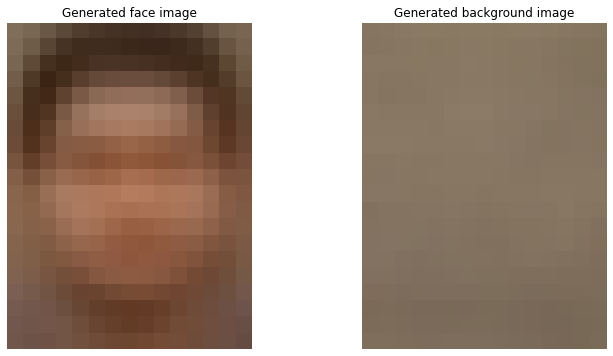

In [45]:
### Visualization face image
generatedIm = origIm.copy() 
k = 0
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][0] = mu_training_face[k][0] # Blue
        k += 1
            
            
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][1] = mu_training_face[k][0] # Green
        k += 1
            
            
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][2] = mu_training_face[k][0] # Red
        k += 1

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(generatedIm, cv2.COLOR_BGR2RGB))
plt.title('Generated face image')
plt.axis("off")

### Visualization background image
generatedIm = origIm.copy() 
k = 0
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][0] = mu_training_bg[k][0] # Blue
        k += 1
            
            
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][1] = mu_training_bg[k][0] # Green
        k += 1
            
            
for j in range(0,ncols):
    for i in range(0,nrows):
        generatedIm[i][j][2] = mu_training_bg[k][0] # Red
        k += 1


            
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(generatedIm, cv2.COLOR_BGR2RGB))
plt.title('Generated background image')
plt.axis("off")
plt.show()